<a href="https://colab.research.google.com/github/Dogdriip/keras-study/blob/main/4_7_Stateful_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7. 시계열수치입력 수치 예측 모델 레시피
- 상태유지 스택 순환신경망 모델

## 1. 데이터셋 준비

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
signal_data = np.cos(np.arange(1600) * (20*np.pi / 1000))[:, None]

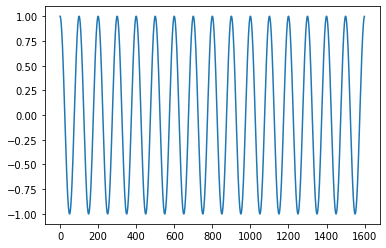

In [39]:
plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

In [40]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data) - look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

In [41]:
# 이전 20개의 수치를 입력하여 다음 수치 1개를 예측 => look_back = 40
look_back = 40

# 데이터 전처리
# -1.0 ~ 1.0 값을 가지는 데이터를 0.0 ~ 1.0 데이터로 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 reshape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## 2. 레이어 준비

## 3. 모델 준비

In [42]:
class CustomHistory(tf.keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [43]:
# 모델 구성하기
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 모델 학습과정 설명하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

760/760 [==============================] - 21s 28ms/step - loss: 0.0030 - val_loss: 2.3743e-04


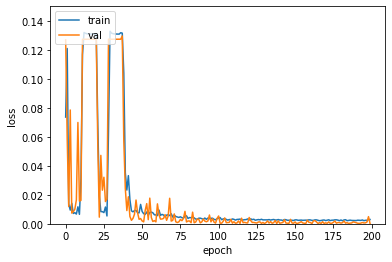

In [44]:
# 학습과정 살펴보기

plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
# 모델 평가
print('train Score: ', model.evaluate(x_train, y_train, batch_size=1, verbose=0))
model.reset_states();
print('val Score: ', model.evaluate(x_val, y_val, batch_size=1, verbose=0))
model.reset_states();
print('test Score: ', model.evaluate(x_test, y_test, batch_size=1, verbose=0))
model.reset_states();

train Score:  0.0002463238488417119
val Score:  0.00023832201259210706
test Score:  0.00023832201259210706


In [46]:
# 모델 사용해서 예측하기

look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=32)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

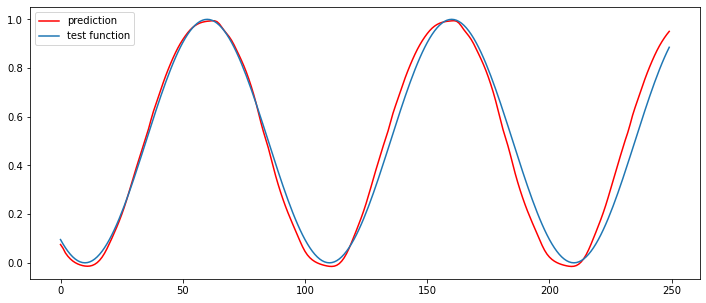

In [47]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label='test function')
plt.legend()
plt.show()